# Fake News Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler


from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline


from collections import Counter

import torch

import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk


import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Functions

In [2]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  df[col].value_counts().plot.bar()
  
def remove_stop_words(review:str):
    word_tokens = " ".join(word_tokenize(review))
    filtered_word_tokens = re.sub(r'[^a-zA-Z\s]', '', word_tokens).split(" ")
    filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_sentence).strip()
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        scores = evaluate_model(X, y, model)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
def grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
            
        grid_search = GridSearchCV(model, param_grid[name], cv=2, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
            
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Test accuracy for {name}: {accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Test Accuracy": accuracy,
                "Best Parameters": grid_search.best_params_
        })


    model_performance_df = pd.DataFrame(model_performance)
    print(model_performance_df)

# EDA Analysis

In [3]:
true_df = pd.read_csv("/Users/maukanmir/Downloads/archive/True.csv",nrows=2500)
fake_df = pd.read_csv("/Users/maukanmir/Downloads/archive/Fake.csv",nrows=2500)

# Create Target Column

In [4]:
fake_df['target'] = 1
true_df['target'] = 0

# Drop Dupes

In [5]:
true_df.drop_duplicates(inplace=True)
fake_df.drop_duplicates(inplace=True)

In [6]:
df = pd.concat([true_df,fake_df]).reset_index()

In [7]:
df.drop("index", axis=1, inplace=True)

# Check Class Imbalance

Class=0, Count=2489, Percentage=49.890%
Class=1, Count=2500, Percentage=50.110%


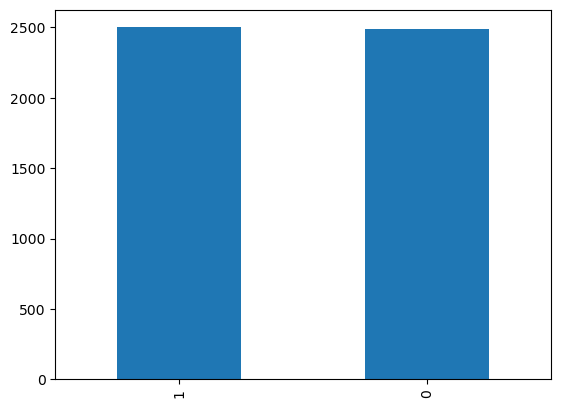

In [8]:

check_class_imbalance(df, df['target'], 'target')

In [9]:
df["date"] = pd.to_datetime(df["date"],errors='coerce', utc=True)

df['year'] = df["date"].dt.year
df['month'] = df["date"].dt.month
df['day'] = df["date"].dt.day

In [10]:
df.drop(['subject', 'date'], inplace=True, axis=1)

In [11]:
df['text'].apply(lambda text: remove_stop_words(text))

0       washington  reuters   head conservative republ...
1       washington  reuters   transgender people allow...
2       washington  reuters   special counsel investig...
3       washington  reuters   trump campaign adviser g...
4       seattlewashington  reuters   president donald ...
                              ...                        
4984    fox news calling donald trump attacking mediaa...
4985    thursday afternoon  world treated donald trump...
4986    donald trump finally held solo press conferenc...
4987    certainly love lost cnn trump administration  ...
4988    vladimir putin super pissed russian media cove...
Name: text, Length: 4989, dtype: object

In [12]:
df['title'].apply(lambda title: remove_stop_words(title))

0       budget fight looms  republicans flip fiscal sc...
1       military accept transgender recruits monday  p...
2           senior republican senator  let mr mueller job
3       fbi russia probe helped australian diplomat ti...
4       trump wants postal service charge  amazon ship...
                              ...                        
4984    watch  fox news host defends cnn reporter  tel...
4985    gop senator desperately worried trump  s menta...
4986    watch  nbc reporter calls trump lying repeated...
4987    tapper slams trump bizarre behavior  wild   un...
4988    lol  putin angry trump gets media coverage rus...
Name: title, Length: 4989, dtype: object

In [13]:
new_df = df.copy()

# Data Pipeline

In [14]:
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
model = DistilBertModel.from_pretrained('distilbert-base-cased')


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]